In [1]:
import os, sys

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from utils.utils import Create_Similarity_Model

sns.set_style('whitegrid')
sns.set_context("talk")

2022-07-27 14:16:02.795903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 14:16:02.795921: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Now we will create our model

In [2]:
n_nonsimilar = 1
n_similar = 1

### We will look for similarity in the last n_similar parameters of the inputs.

## Load the MVP data for high enough Re

In [3]:
df_full=pd.ExcelFile("../../Data/Boundary Layer Data/BL_Data_Final_Vallikivi_etal_2015.xlsx")
df_NSTAP = pd.read_excel(df_full, 'NSTAP_data')
df_Pitot = pd.read_excel(df_full, 'Pitot_Data')
df_NSTAP_utau = pd.read_excel(df_full, 'NSTAP_Utau')
df_NSTAP_prop = pd.read_excel(df_full, 'NSTAP_Prop')

dfs = []
Re_tau = []
Y_ = []
U_ = []
possible_re_tau = [2621.5, 4634.5, 8261.3, 14717.0, 25062.0, 40053.0, 72526.0]
u_tau = df_NSTAP_utau.iloc[:, 1].values
u_inf = df_NSTAP_prop.iloc[:, 1]
dic_x = {}
dic_y = {}

for i in range(2, len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    for j in range(len(possible_y)):
        if possible_y[j] > 0.1 * possible_re_tau[i]:
            Y_.append(possible_y[j])
            U_.append(possible_u[j])
            Re_tau.append(possible_re_tau[i])

c = list(zip(Y_, Re_tau, U_))
random.shuffle(c)
Y_, Re_tau, U_ = zip(*c)

Y_ = np.log(Y_)
Re_tau = np.log(Re_tau)

dic_x['y+'] = Y_
dic_x['re_tau'] = Re_tau
dic_y['u+'] = np.array(U_)

nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values

In [4]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 20                       # Number of model fits we will try to perform
n_epochs_initial = 100           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0
models = []

# model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
# model.compile(loss = loss, optimizer = optimizer)
# model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 2)

while successfull_tries < n_fits:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    if current_loss < 200:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        models.append(model)
        print("Iteration " + str(successfull_tries) + ": current loss = " + str(good_loss))
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

2022-07-22 13:02:48.235209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 13:02:48.235742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 13:02:48.235882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-22 13:02:48.235973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-22 13:02:48.236031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Iteration 1: current loss = 0.05018178001046181
Iteration 2: current loss = 0.04420262202620506
Iteration 3: current loss = 0.03557847812771797
Iteration 4: current loss = 0.14810460805892944
Iteration 5: current loss = 0.026401352137327194
Iteration 6: current loss = 0.029403625056147575
Iteration 7: current loss = 0.044676896184682846
Iteration 8: current loss = 0.02882014401257038
Iteration 9: current loss = 0.21455231308937073
Iteration 10: current loss = 0.02703629992902279
Iteration 11: current loss = 0.057785410434007645
Iteration 12: current loss = 0.08637171983718872
Iteration 13: current loss = 173.8382110595703
Iteration 14: current loss = 0.024693505838513374
Iteration 15: current loss = 0.06681661307811737
Iteration 16: current loss = 0.044521432369947433
Iteration 17: current loss = 173.46826171875
Iteration 18: current loss = 0.032171864062547684
Iteration 19: current loss = 0.028767477720975876
Iteration 20: current loss = 0.036862991750240326


In [5]:
# best_model.fit(xtrain, ytrain, epochs = 10000, verbose = 0)
best_model.evaluate(xtrain, ytrain, verbose = 0)

0.024693505838513374

In [7]:
j = 0

for model in models:

    for i in range(n_nonsimilar):
        similarity_exponents = model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
        print('Exponents multiplicating inside the function for model ' + str(j) + ' in ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

    multiplication_exponents = model.get_layer('multiplication_layer').weights[0][0].numpy()
    print('Exponents multiplicating outside the function for model ' + str(j) + ': '  + str(multiplication_exponents))
    j += 1

for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
    print('Exponents multiplicating inside the function for  best model: ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function for best model: '  + str(multiplication_exponents))

Exponents multiplicating inside the function for model 0 in y+: [-0.98794574]
Exponents multiplicating outside the function for model 0: [0.0803861]
Exponents multiplicating inside the function for model 1 in y+: [-0.98847085]
Exponents multiplicating outside the function for model 1: [0.08033992]
Exponents multiplicating inside the function for model 2 in y+: [-0.948074]
Exponents multiplicating outside the function for model 2: [0.07723189]
Exponents multiplicating inside the function for model 3 in y+: [-0.28096473]
Exponents multiplicating outside the function for model 3: [0.00868509]
Exponents multiplicating inside the function for model 4 in y+: [-0.89808]
Exponents multiplicating outside the function for model 4: [0.07332056]
Exponents multiplicating inside the function for model 5 in y+: [-0.92933744]
Exponents multiplicating outside the function for model 5: [0.07580342]
Exponents multiplicating inside the function for model 6 in y+: [-0.90418303]
Exponents multiplicating out

In [4]:
scaling_factor_y = 0.98847085
scaling_factor_u = 0.08033992

y__ = []
u__ = []
Re_tau = possible_re_tau
Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

for i in range(len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    y__.append(possible_y / (Re_tau[i] ** scaling_factor_y))
    u__.append(possible_u / (Re_tau[i] ** scaling_factor_u))

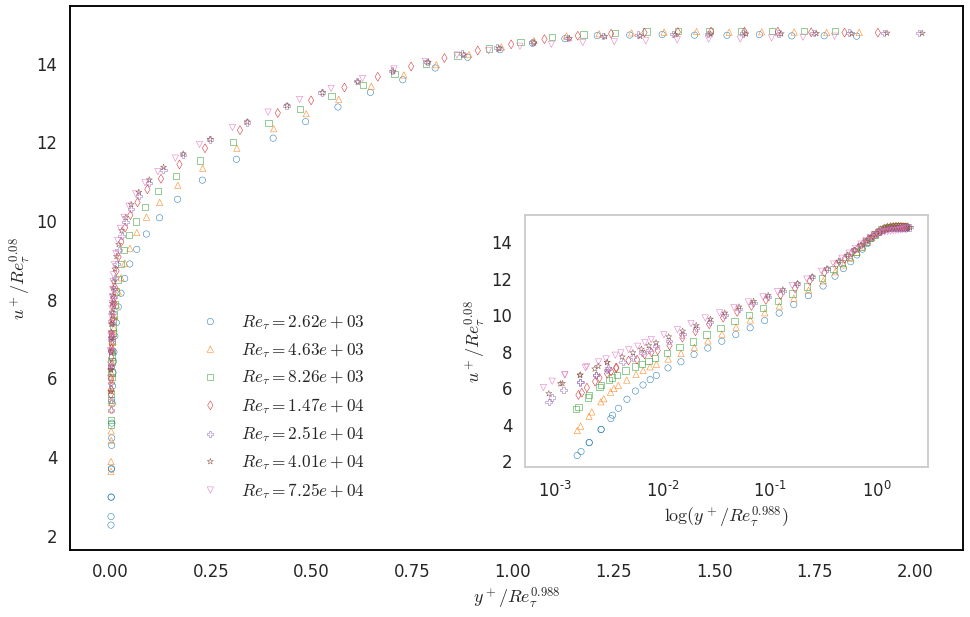

In [5]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_re_tau)):
    ax1.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(possible_re_tau)):
    ax2.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Re= '+'{:.2e}'.format(possible_re_tau[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+/Re_\tau^{0.988}$")
ax1.set_ylabel(r'$u^+/Re_\tau^{0.08}$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau^{0.988})$")
ax2.set_ylabel(r'$u^+/Re_\tau^{0.08}$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/BarenNet exponents for Boundary Layer.pdf', format='pdf', dpi=1200)
plt.show()

In [4]:
scaling_factor_y = 0
scaling_factor_u = 0

y__ = []
u__ = []
Re_tau = possible_re_tau
Re = [2.36e+006, 3.11e+006, 4.46e+006, 6.11e+006, 7.81e+006, 1.03e+007, 1.37e+007]

for i in range(len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    y__.append(possible_y / (Re_tau[i] ** scaling_factor_y))
    u__.append(possible_u / (Re_tau[i] ** scaling_factor_u))

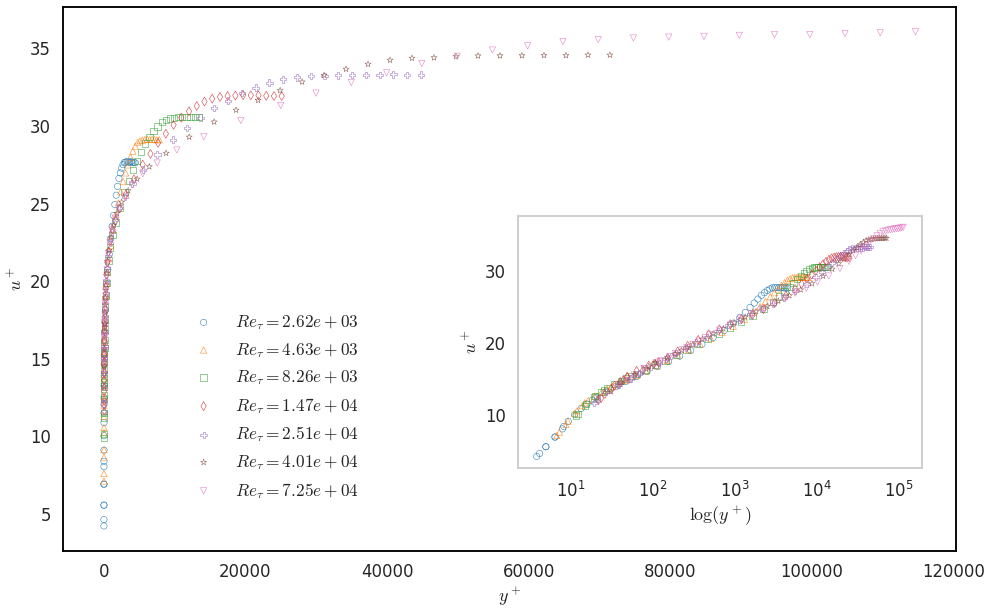

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_re_tau)):
    ax1.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(possible_re_tau)):
    ax2.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Re= '+'{:.2e}'.format(possible_re_tau[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+$")
ax1.set_ylabel(r'$u^+$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+)$")
ax2.set_ylabel(r'$u^+$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/BarenNet u+_y+ for Boundary Layer.pdf', format='pdf', dpi=1200)
plt.show()

In [14]:
scaling_factor_y = 1.00
scaling_factor_u = 1/12

y__ = []
u__ = []
Re_tau = possible_re_tau

for i in range(len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    y__.append(possible_y / (Re_tau[i] ** scaling_factor_y))
    u__.append(possible_u / (Re_tau[i] ** scaling_factor_u))

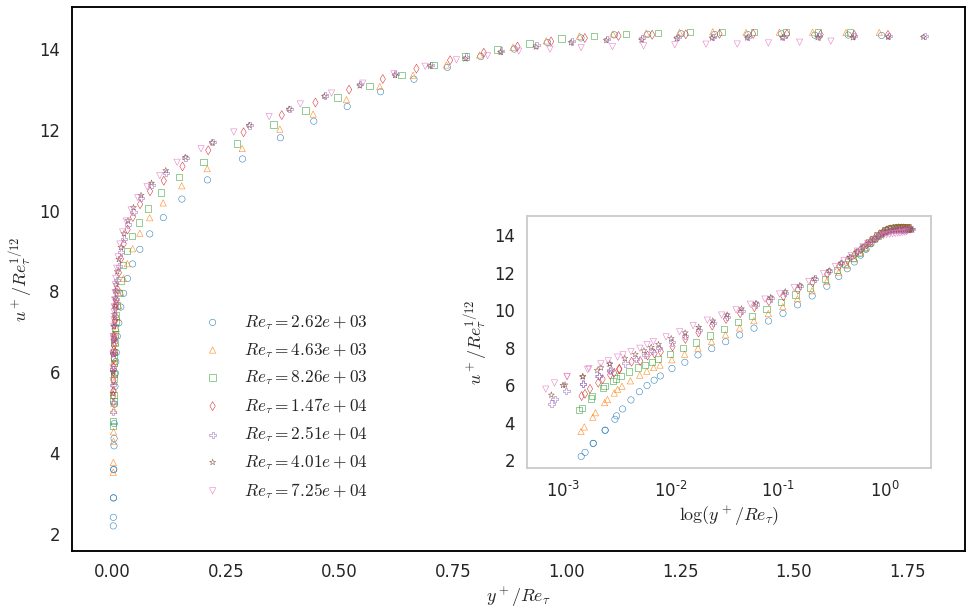

In [16]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_re_tau)):
    ax1.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(possible_re_tau)):
    ax2.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Re= '+'{:.2e}'.format(possible_re_tau[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+/Re_\tau$")
ax1.set_ylabel(r'$u^+/Re_\tau^{1/12}$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau)$")
ax2.set_ylabel(r'$u^+/Re_\tau^{1/12}$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/Theoretical exponents for Boundary Layer.pdf', format='pdf', dpi=1200)
plt.show()

In [21]:
scaling_factor_y = 1.00

y__ = []
u__ = []
Re_tau = possible_re_tau

for i in range(len(possible_re_tau)):
    possible_y = df_NSTAP.iloc[2:, 4*i].values
    possible_u = df_NSTAP.iloc[2:, 4*i + 1].values
    y__.append(possible_y / (Re_tau[i] ** scaling_factor_y))
    u__.append(possible_u  * (u_tau[i] / u_inf[i]))

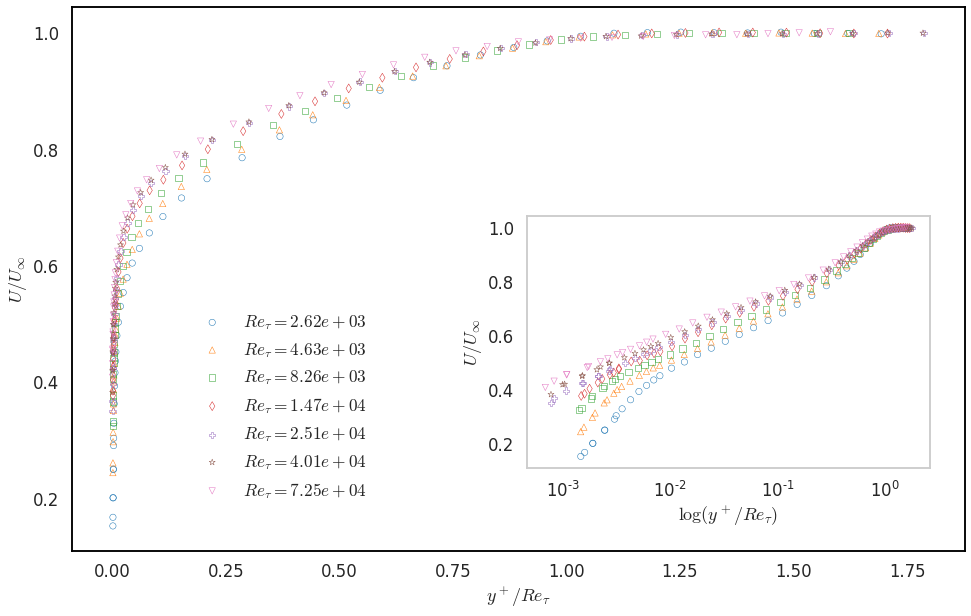

In [23]:
fig, ax1 = plt.subplots(figsize=(16, 10))

left, bottom, width, height = [0.52, 0.24, 0.35, 0.35] 
ax2 = fig.add_axes([left, bottom, width, height])

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_re_tau)):
    ax1.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.2e}$'.format(possible_re_tau[i]))
    j+=1

j=0
for i in range(len(possible_re_tau)):
    ax2.scatter(y__[i] , u__[i] , s=40 , linewidth = line_width, facecolors = 'none', color = colors[i] , marker = markers[j%len(markers)], label = 'Re= '+'{:.2e}'.format(possible_re_tau[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.13, 0.45), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+/Re_\tau$")
ax1.set_ylabel(r'$U/U_\infty$')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
ax2.set_xlabel(r"$\log(y^+/Re_\tau)$")
ax2.set_ylabel(r'$U/U_\infty$')
ax2.set_xscale('log')
#ax2.set_xlim([0.01,1])
ax2.grid(False)
plt.savefig('Figures/u_inf normalization for Boundary Layer.pdf', format='pdf', dpi=1200)
plt.show()